In [106]:
from Dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import VAE
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
import helper
from torchinfo import summary
import numpy as np 
from sklearn.manifold import TSNE

In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# !bash download.sh afhq-dataset

In [109]:
# Create a dataset and a DataLoader
transforms = {'val':transforms.Compose([
    transforms.Resize([64, 64]),  # Resize the image first
    transforms.ToTensor(),        # Convert PIL image to tensor
]),
'train':transforms.Compose([
    transforms.Resize([64, 64]),  # Resize the image first
    transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    transforms.ToTensor(),        # Convert PIL image to tensor
])
}


root_dir = "/home/user/elwakeely1/Cuda_Vision_Lab-/Session5/Solution/data/afhq"

# Initialize dataset
train_dataset = Dataset(root_dir=root_dir, split="train", transform=transforms["train"])
test_dataset = Dataset(root_dir=root_dir, split="val", transform=transforms["val"])


In [110]:
print(f"train size: {train_dataset.__len__()}\ntest size: {test_dataset.__len__()}")

train size: 14630
test size: 1500


In [111]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=8,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=8,pin_memory=True)
print("test_dataset per epoch",next(iter(test_loader))[0].size())

test_dataset per epoch torch.Size([64, 1, 64, 64])


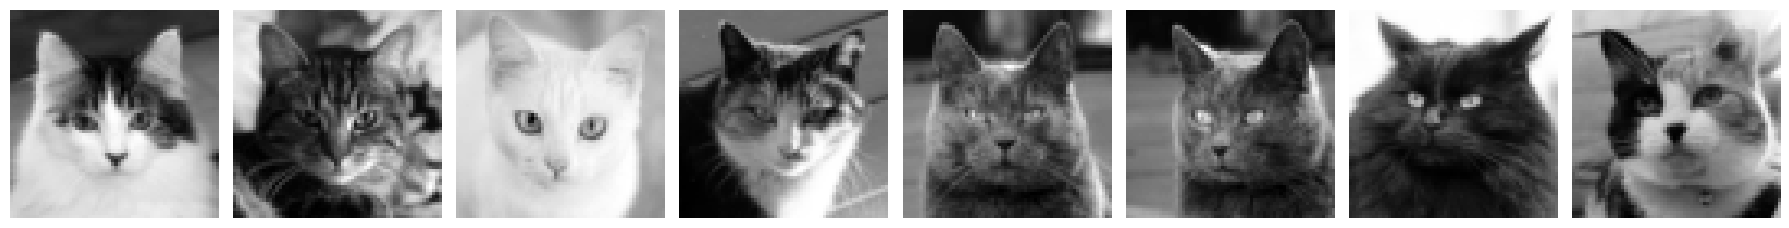

In [112]:
imgs, _ = next(iter(test_loader)) 
fig, ax = plt.subplots(1, 8, figsize=(18, 5))  
for i in range(8):
    ax[i].imshow(imgs[i].squeeze(0), cmap="gray")  
    ax[i].axis("off")
plt.tight_layout()
plt.show()

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
helper.set_random_seed()

Random seed set to: 13


# Vanilla VAE 

In [114]:
vae = VAE.VanillaVAE(in_size=(1,64,64), sizes=[4096, 1256, 512, 16], act="ReLU")
vae = vae.to(device)
summary(vae,input_size=((1,64,64)))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaVAE                               [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 512]                  643,584
│    └─Flatten: 2-1                      [1, 4096]                 --
│    └─Linear: 2-2                       [1, 1256]                 5,145,832
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-3                         [1, 1256]                 --
├─Sequential: 1-3                        --                        (recursive)
│    └─Linear: 2-4                       [1, 512]                  643,584
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-5                         [1, 512]                  --
├─Linear: 1-5                            [1, 16]                   8,208
├─Linear: 1-6                            [1, 16]                   8,208
├─Sequential: 1-7                  

In [115]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [116]:
writer = helper.new_writer("models","VanillaVAE")
train = Wrapper(model_name="VanillaVAE", model = vae, device = device, criterion = helper.vae_loss_function, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader)
writer.close()

Epoch 1 Iter 229: loss 0.04404.: 100%|██████████| 229/229 [00:06<00:00, 38.00it/s]


Train Loss 0.05045
Test Loss 0.04445
    Test recons_Loss 0.04057
    Test kld_Loss 3.87175


Epoch 2 Iter 229: loss 0.04271.: 100%|██████████| 229/229 [00:05<00:00, 38.87it/s]


Train Loss 0.04108
Test Loss 0.03859
    Test recons_Loss 0.0334
    Test kld_Loss 5.18611


Epoch 3 Iter 229: loss 0.03748.: 100%|██████████| 229/229 [00:05<00:00, 38.52it/s]


Train Loss 0.03837
Test Loss 0.03737
    Test recons_Loss 0.03286
    Test kld_Loss 4.50855


Epoch 4 Iter 229: loss 0.03510.: 100%|██████████| 229/229 [00:06<00:00, 37.94it/s]


Train Loss 0.03748
Test Loss 0.03658
    Test recons_Loss 0.03112
    Test kld_Loss 5.45839


Epoch 5 Iter 229: loss 0.03298.: 100%|██████████| 229/229 [00:05<00:00, 38.79it/s]


Train Loss 0.03607
Test Loss 0.03517
    Test recons_Loss 0.02998
    Test kld_Loss 5.19139


Epoch 6 Iter 229: loss 0.03248.: 100%|██████████| 229/229 [00:05<00:00, 39.04it/s]


Train Loss 0.03571
Test Loss 0.03539
    Test recons_Loss 0.03036
    Test kld_Loss 5.03409


Epoch 7 Iter 229: loss 0.03291.: 100%|██████████| 229/229 [00:05<00:00, 38.28it/s]


Train Loss 0.03539
Test Loss 0.0347
    Test recons_Loss 0.02983
    Test kld_Loss 4.8678


Epoch 8 Iter 229: loss 0.03377.: 100%|██████████| 229/229 [00:06<00:00, 37.47it/s]


Train Loss 0.03526
Test Loss 0.03494
    Test recons_Loss 0.03027
    Test kld_Loss 4.67178


Epoch 9 Iter 229: loss 0.03558.: 100%|██████████| 229/229 [00:05<00:00, 38.35it/s]


Train Loss 0.03518
Test Loss 0.03469
    Test recons_Loss 0.02988
    Test kld_Loss 4.8056


Epoch 10 Iter 229: loss 0.03295.: 100%|██████████| 229/229 [00:05<00:00, 39.48it/s]


Train Loss 0.03513
Test Loss 0.03449
    Test recons_Loss 0.02949
    Test kld_Loss 4.99483


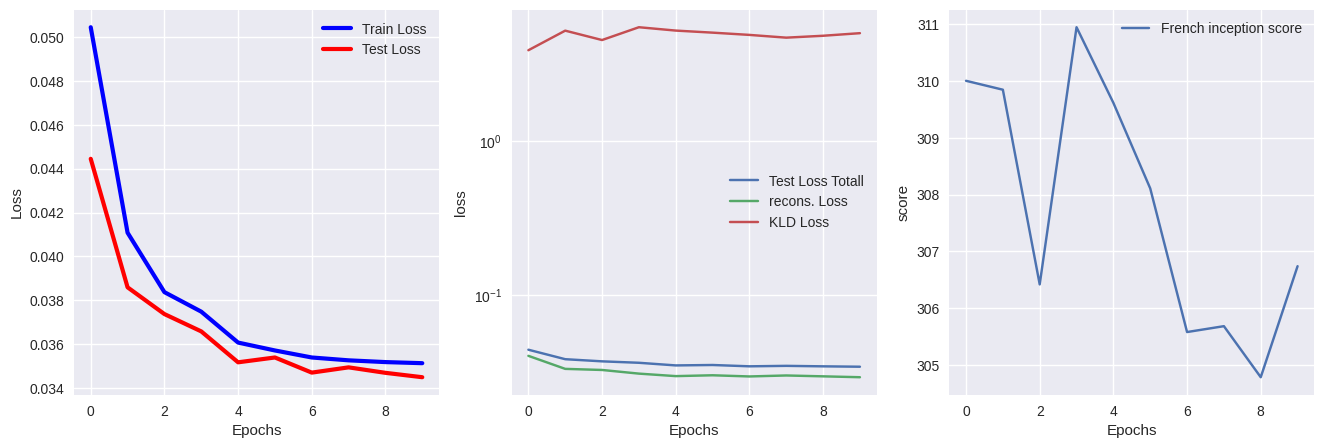

In [117]:
train.plot_loss_acc()

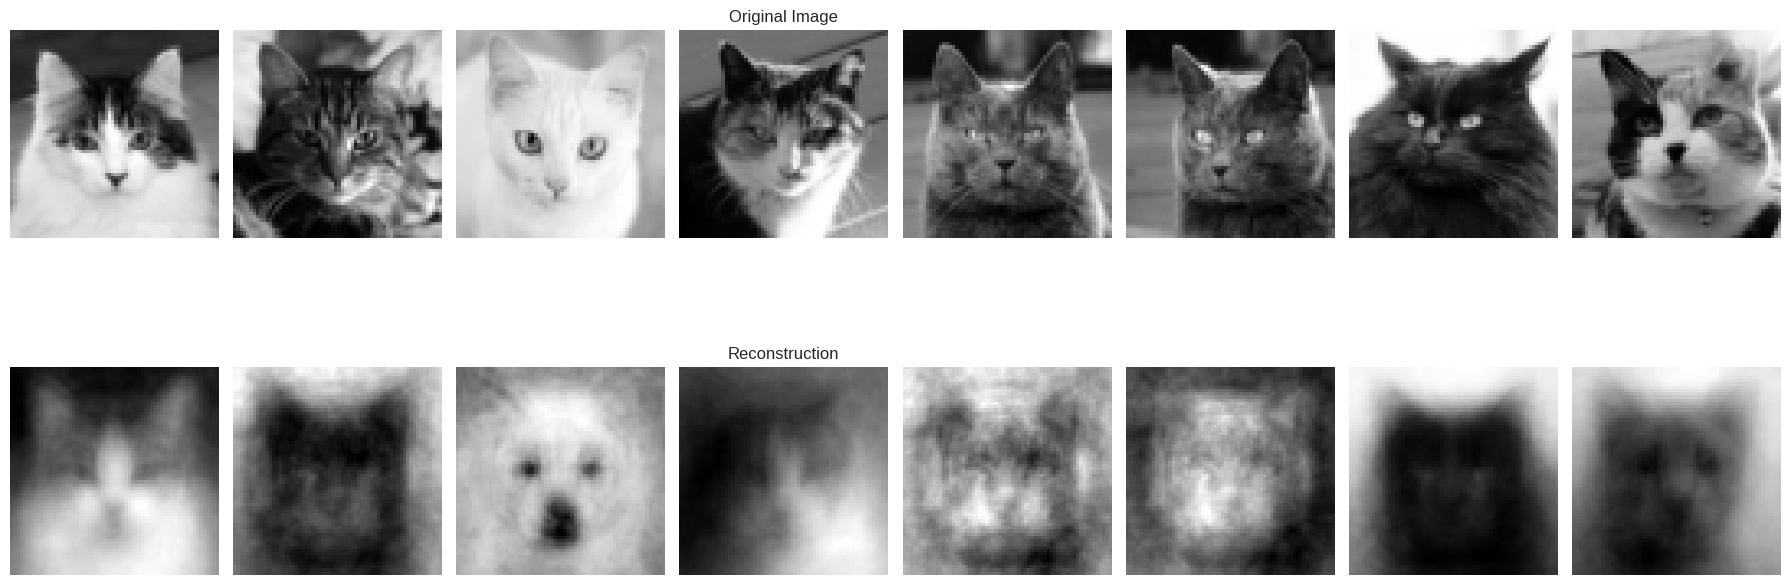

In [118]:
imgs, _ = next(iter(test_loader)) 

vae.eval()
with torch.no_grad():
    recons, _ = vae(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [119]:
# our latent space (bottleneck) is 64-dim
LATENT_DIM = 16
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs = vae.decoder(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 64, 64)

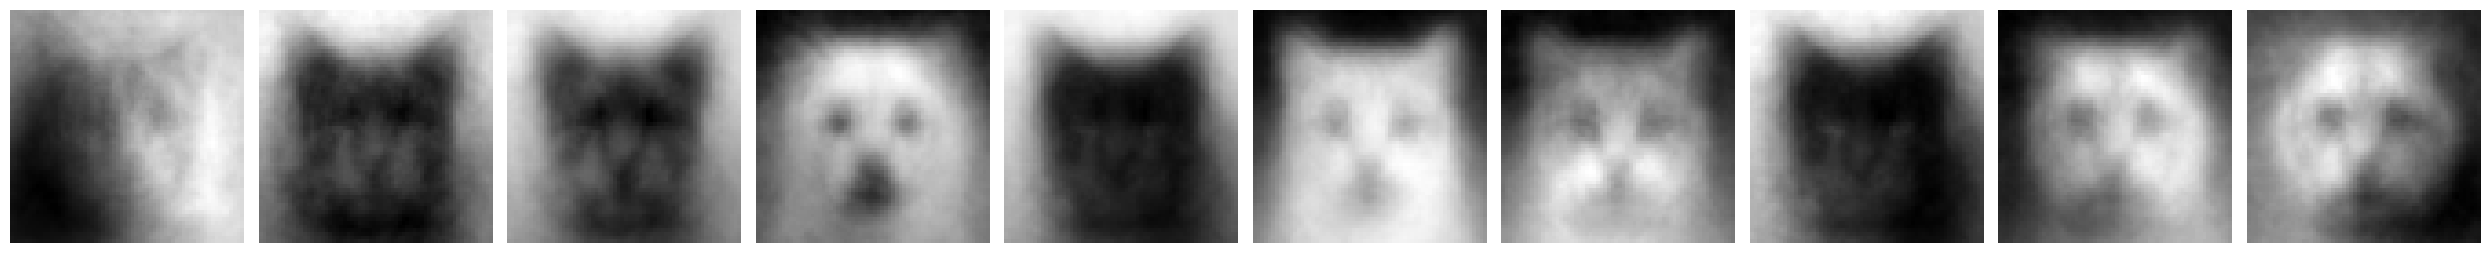

In [120]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [121]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [122]:
COLORS = ['r','b','g']
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

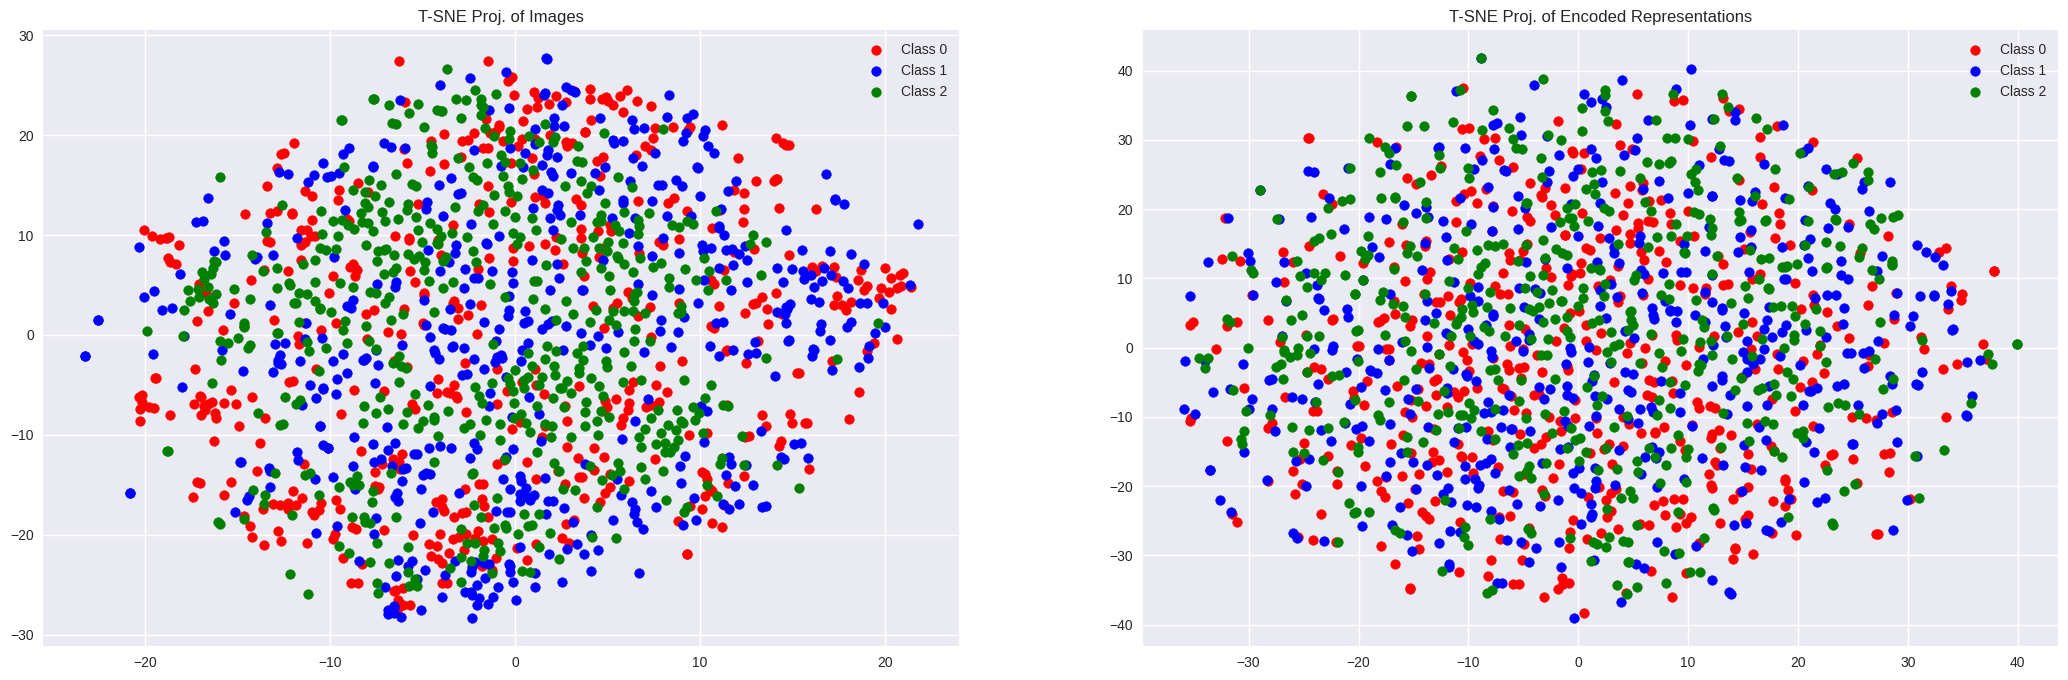

In [123]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

# Convolution Variational autoencoder 

In [124]:
LATENT_DIM = 10
conv_vae = VAE.ConvVAE(latent_dim=LATENT_DIM)
conv_vae = conv_vae.to(device)
summary(conv_vae,input_size=(1,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE                                  [1, 1, 64, 64]            --
├─Sequential: 1-1                        [512, 4, 4]               --
│    └─Conv2d: 2-1                       [64, 32, 32]              1,088
│    └─ReLU: 2-2                         [64, 32, 32]              --
│    └─Conv2d: 2-3                       [128, 16, 16]             131,200
│    └─ReLU: 2-4                         [128, 16, 16]             --
│    └─Conv2d: 2-5                       [256, 8, 8]               524,544
│    └─ReLU: 2-6                         [256, 8, 8]               --
│    └─Conv2d: 2-7                       [512, 4, 4]               2,097,664
│    └─ReLU: 2-8                         [512, 4, 4]               --
├─Linear: 1-2                            [1, 10]                   81,930
├─Linear: 1-3                            [1, 10]                   81,930
├─Linear: 1-4                            [1, 8192]       

In [125]:
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=3e-3)
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [126]:
writer = helper.new_writer("models","ConvVAE")
train = Wrapper(model_name="COnvVAE", model = conv_vae, device = device, criterion = helper.vae_loss_function, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader)
writer.close()

Epoch 1 Iter 229: loss 0.03798.: 100%|██████████| 229/229 [00:05<00:00, 38.81it/s]


Train Loss 0.04756
Test Loss 0.03543
    Test recons_Loss 0.02906
    Test kld_Loss 6.36502


Epoch 2 Iter 229: loss 0.03152.: 100%|██████████| 229/229 [00:05<00:00, 38.42it/s]


Train Loss 0.03415
Test Loss 0.03349
    Test recons_Loss 0.0262
    Test kld_Loss 7.29122


Epoch 3 Iter 229: loss 0.03366.: 100%|██████████| 229/229 [00:05<00:00, 38.52it/s]


Train Loss 0.03341
Test Loss 0.03293
    Test recons_Loss 0.02572
    Test kld_Loss 7.21014


Epoch 4 Iter 229: loss 0.03285.: 100%|██████████| 229/229 [00:06<00:00, 37.88it/s]


Train Loss 0.03321
Test Loss 0.03307
    Test recons_Loss 0.02537
    Test kld_Loss 7.69871


Epoch 5 Iter 229: loss 0.03445.: 100%|██████████| 229/229 [00:05<00:00, 38.35it/s]


Train Loss 0.03309
Test Loss 0.03275
    Test recons_Loss 0.02552
    Test kld_Loss 7.23307


Epoch 6 Iter 229: loss 0.03671.: 100%|██████████| 229/229 [00:06<00:00, 37.68it/s]


Train Loss 0.03303
Test Loss 0.03278
    Test recons_Loss 0.02588
    Test kld_Loss 6.90415


Epoch 7 Iter 229: loss 0.03427.: 100%|██████████| 229/229 [00:05<00:00, 38.40it/s]


Train Loss 0.03302
Test Loss 0.03272
    Test recons_Loss 0.02512
    Test kld_Loss 7.59384


Epoch 8 Iter 229: loss 0.03199.: 100%|██████████| 229/229 [00:06<00:00, 37.65it/s]


Train Loss 0.03295
Test Loss 0.03291
    Test recons_Loss 0.02531
    Test kld_Loss 7.60399


Epoch 9 Iter 229: loss 0.03393.: 100%|██████████| 229/229 [00:06<00:00, 36.77it/s]


Train Loss 0.0329
Test Loss 0.03263
    Test recons_Loss 0.02528
    Test kld_Loss 7.34888


Epoch 10 Iter 229: loss 0.03221.: 100%|██████████| 229/229 [00:05<00:00, 39.38it/s]


Train Loss 0.03279
Test Loss 0.03263
    Test recons_Loss 0.02533
    Test kld_Loss 7.30565


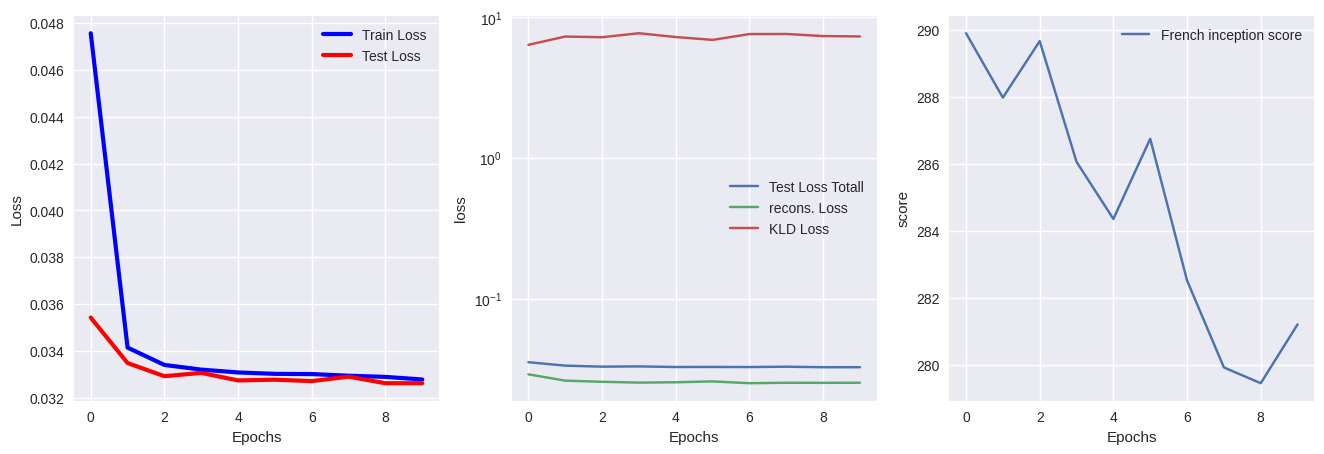

In [127]:
train.plot_loss_acc()

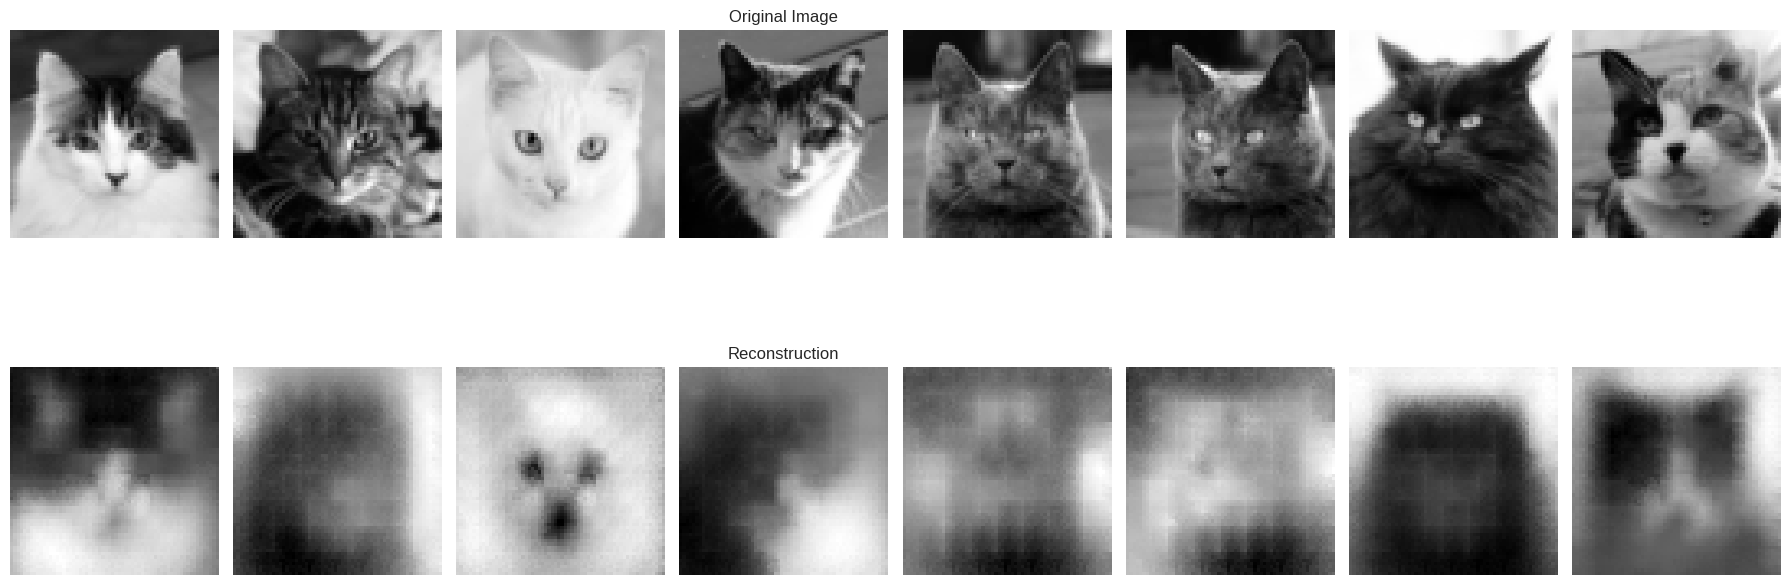

In [128]:
helper.show_recons_test(test_loader,conv_vae,device)

In [129]:
# our latent space (bottleneck) is 64-dim
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs =conv_vae.decode(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 64, 64)

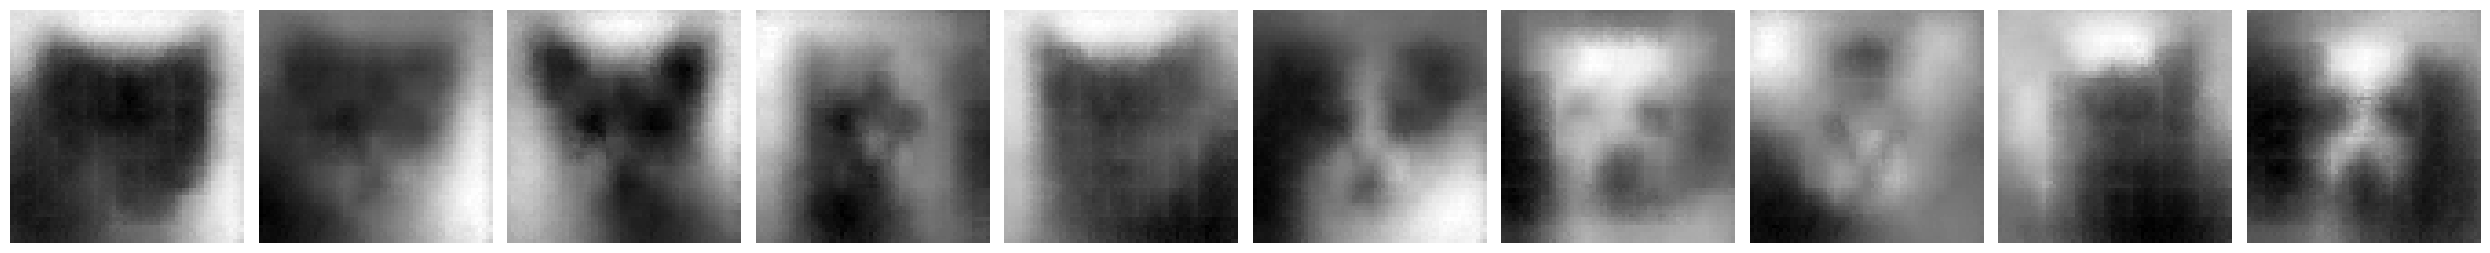

In [130]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [131]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = conv_vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [132]:
COLORS = ['r','b','g']
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

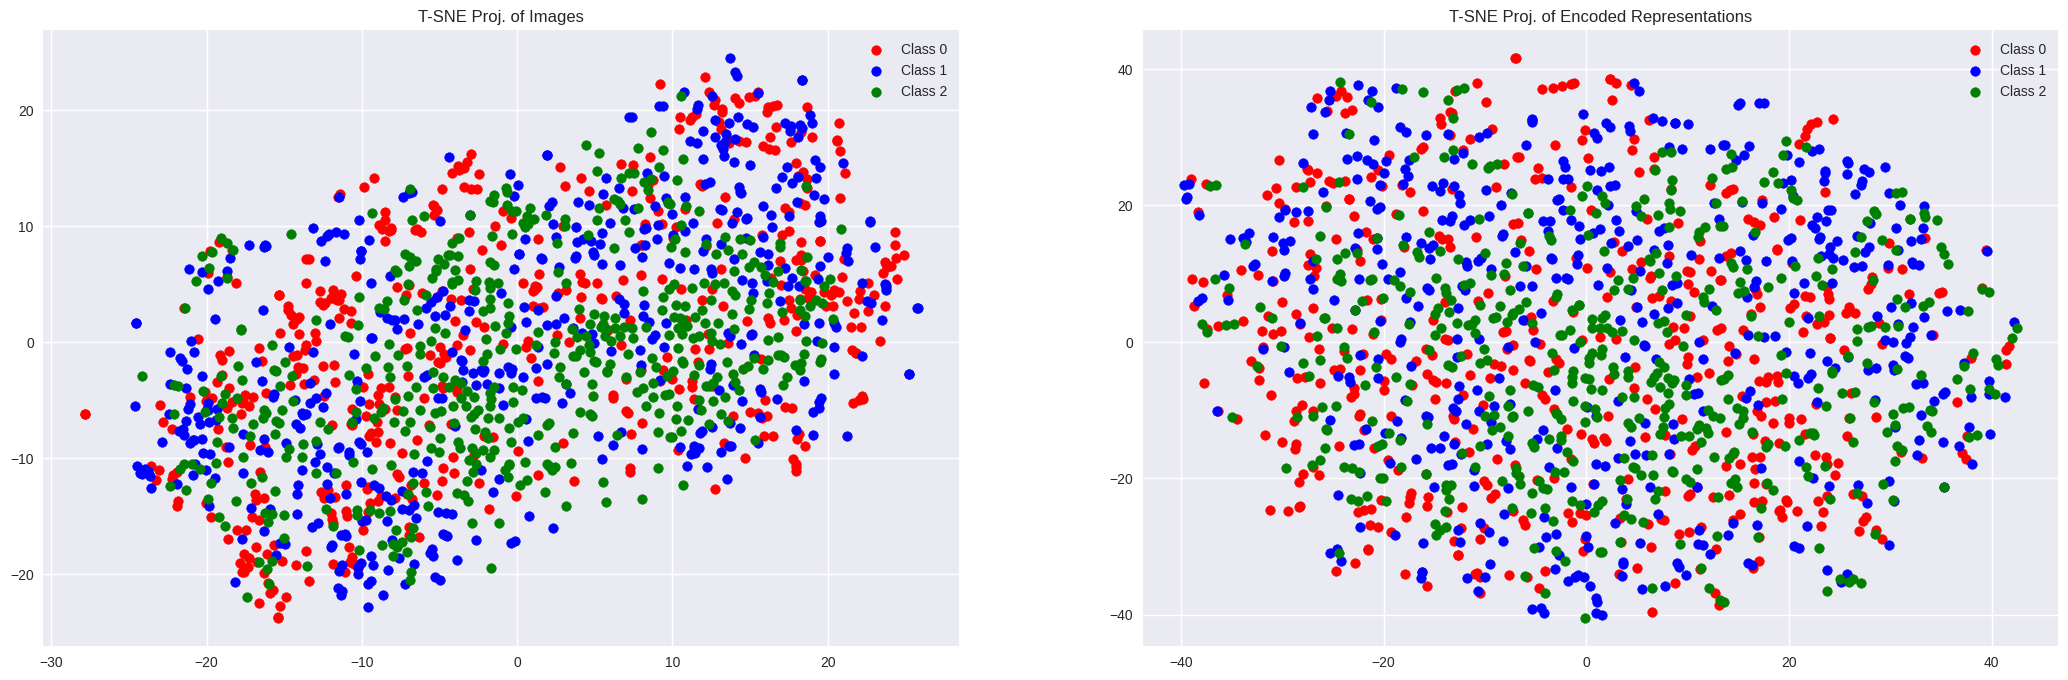

In [133]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

## Interpolation

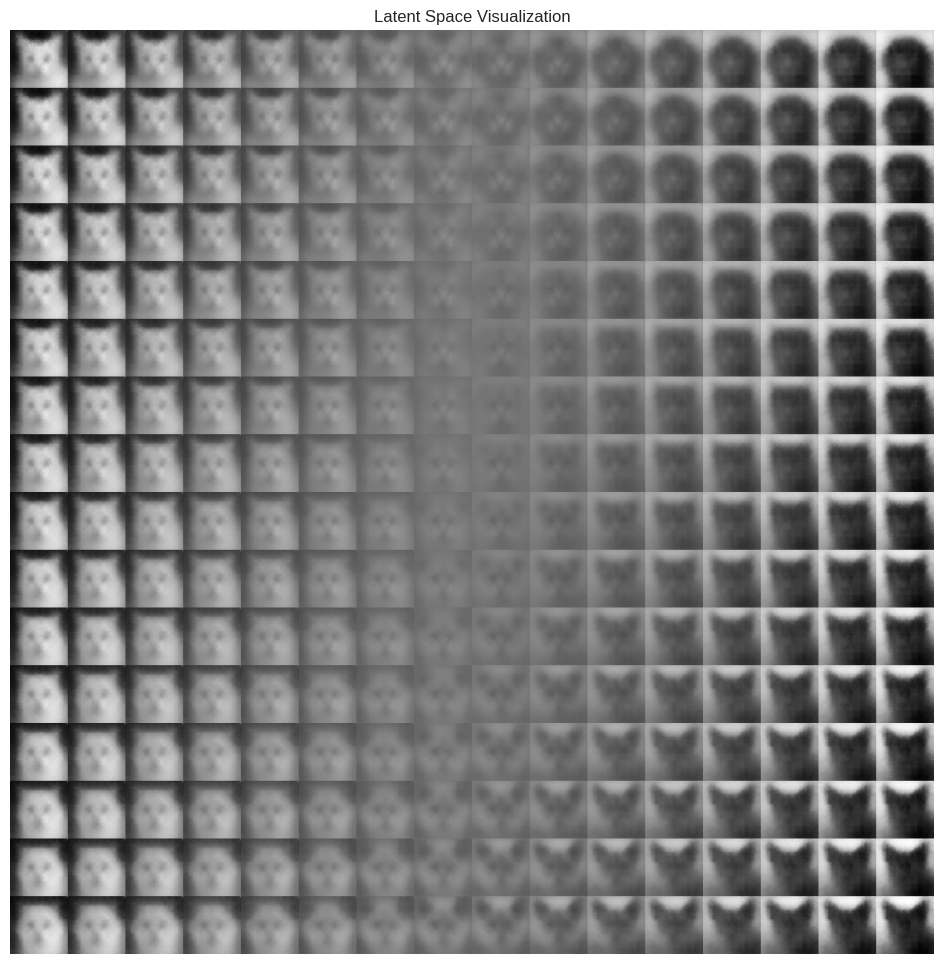

In [134]:
helper.plot_reconstructed(conv_vae, xrange=(-3, 3), yrange=(-3, 3), resolution=16, image_size=64,device = device)


# Clustering 

In [135]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [136]:
kmeans_imgs = KMeans(n_clusters=15, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=15, random_state=0).fit(latents)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/user/elwakeely1/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [137]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [138]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=1.37%
Clustering latents achieves ARI=1.55%


In [139]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 10/4096  = 0.24%


# Train using different kl divergence weights 

kld_weight = 0.0001


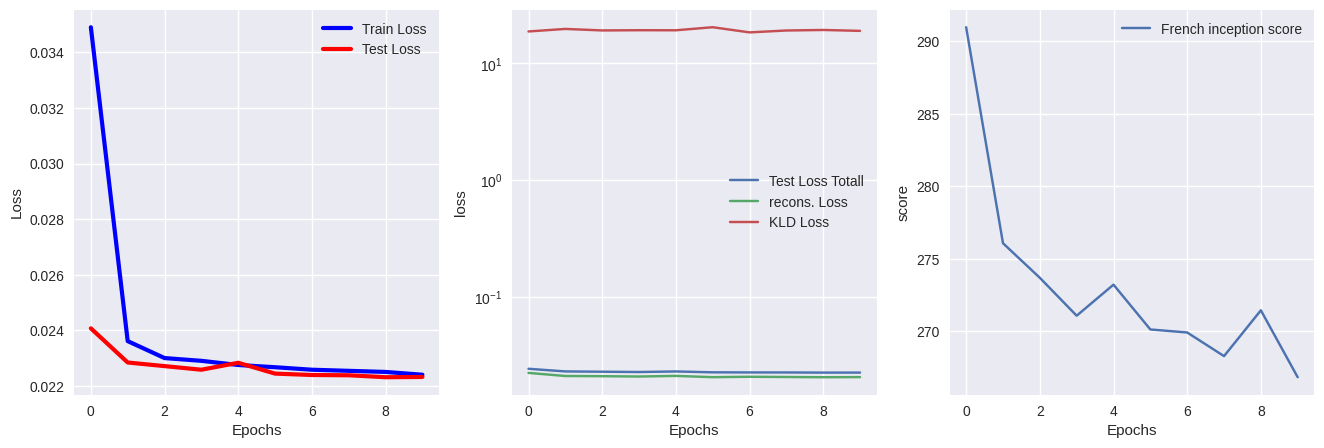

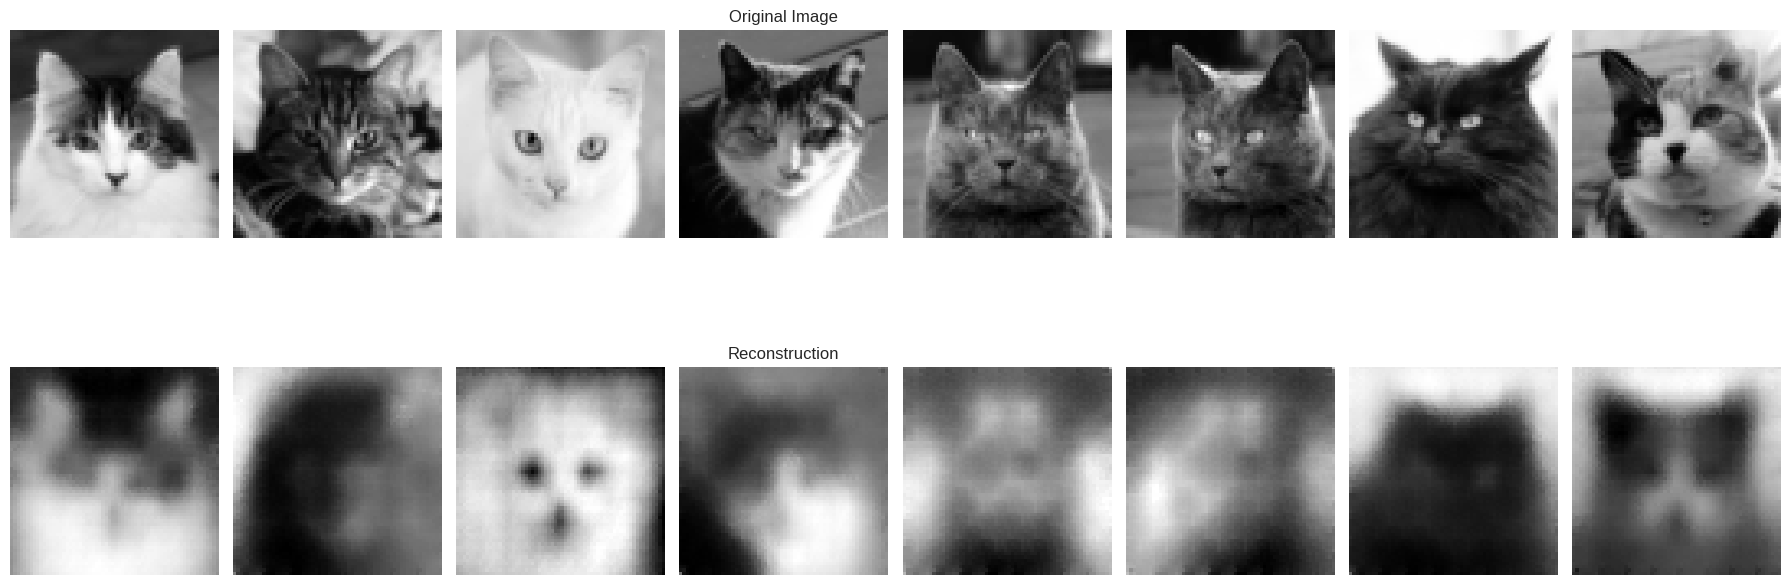

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


kld_weight = 0.001


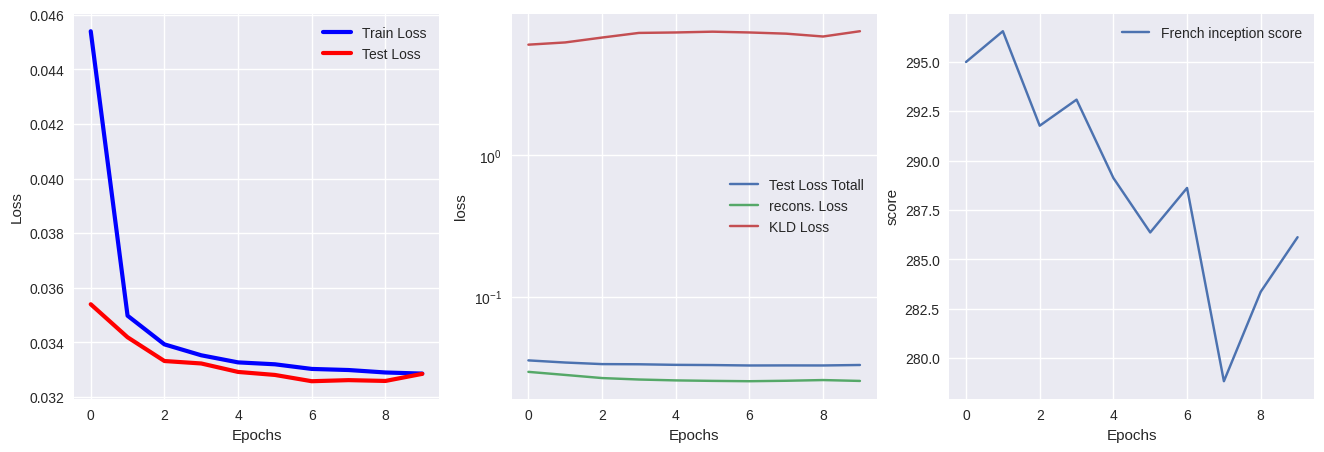

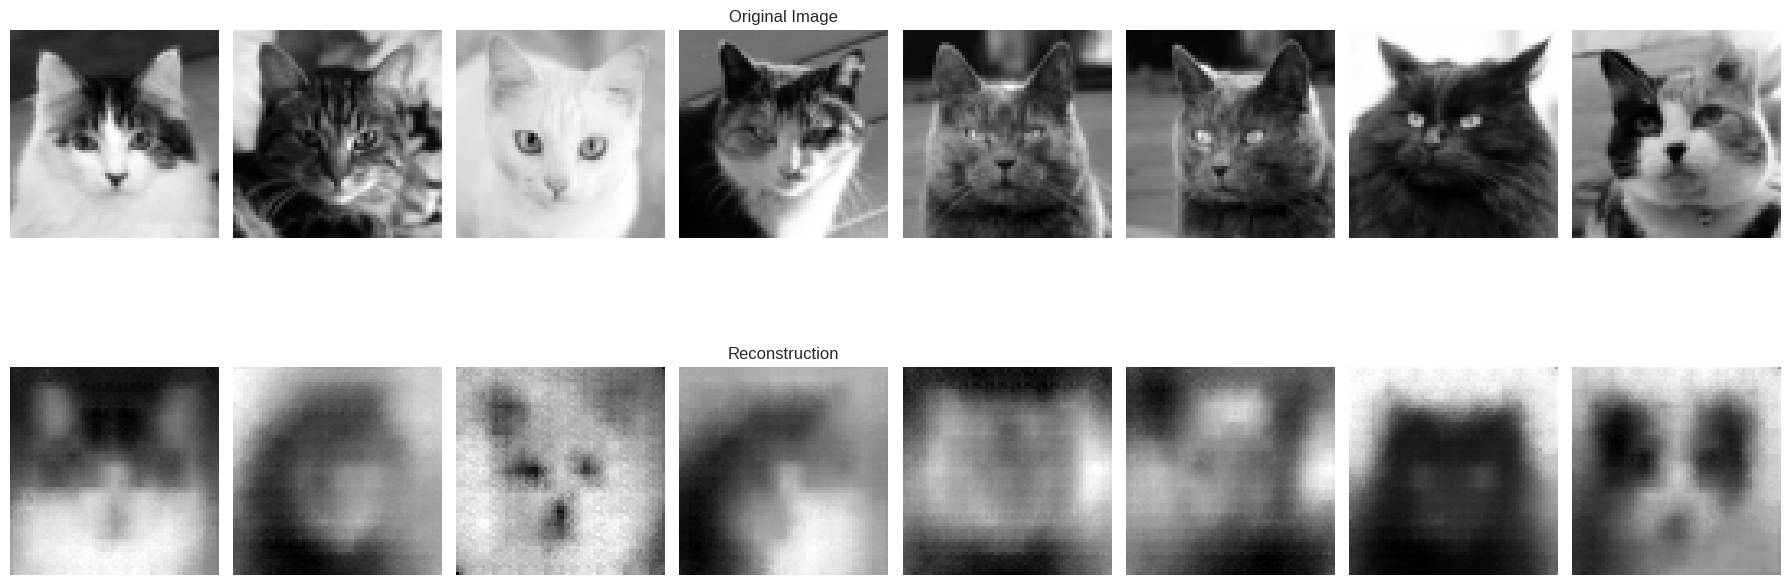

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


kld_weight = 0.01


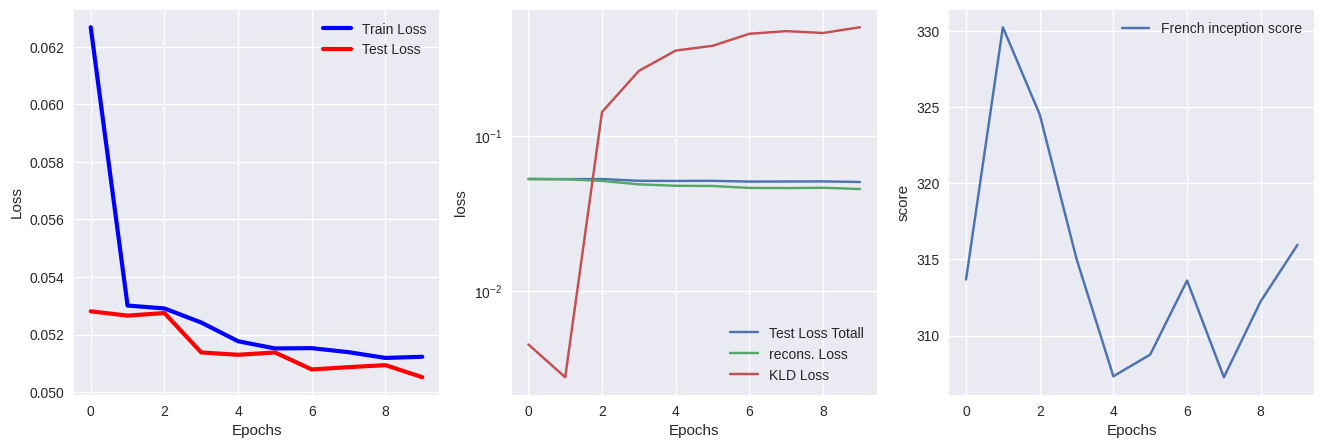

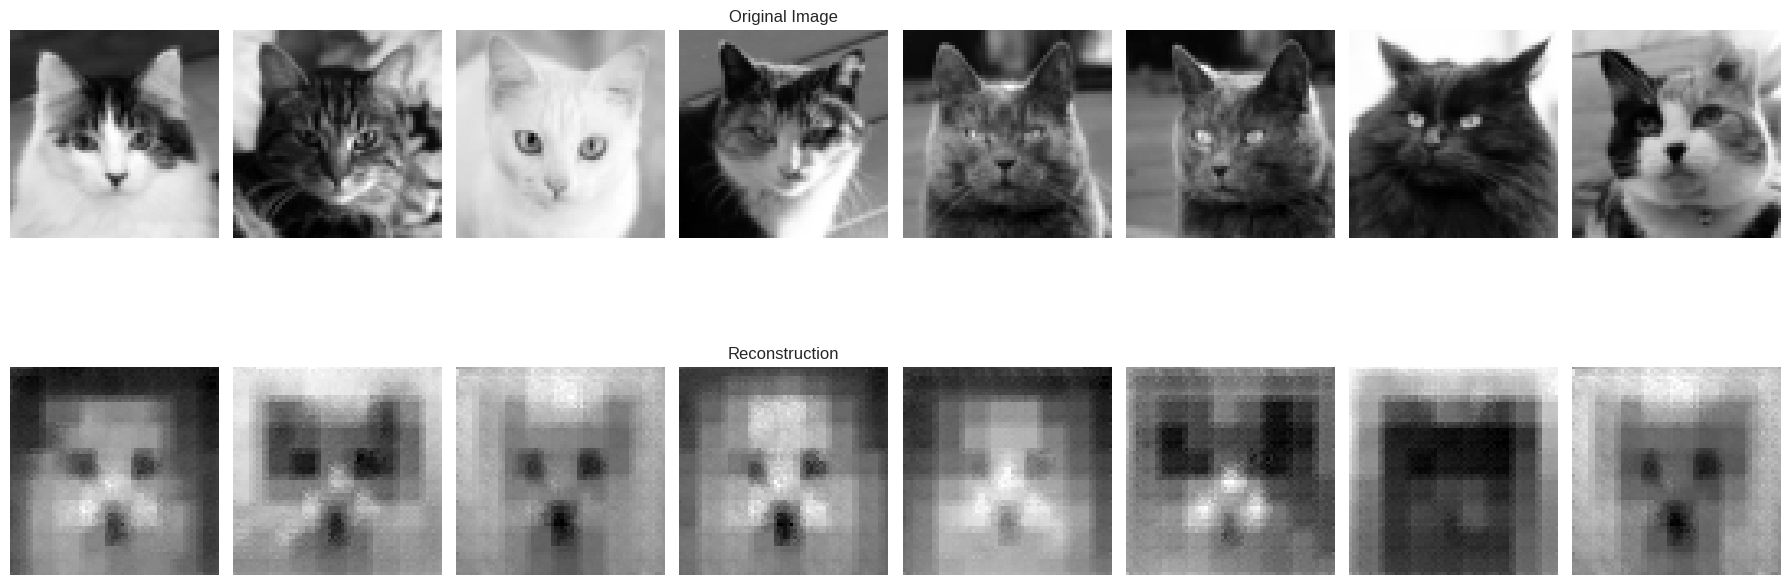

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


kld_weight = 0.1


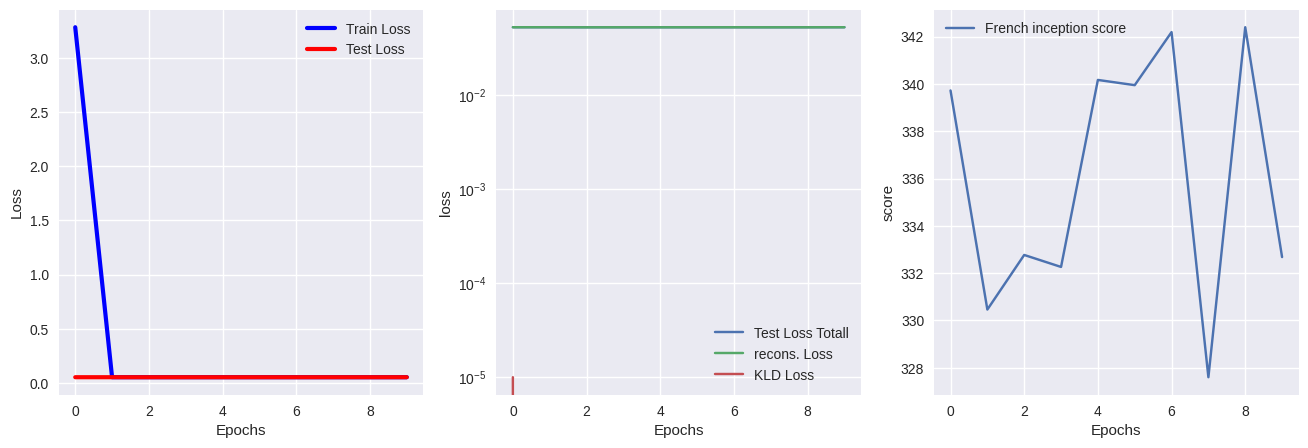

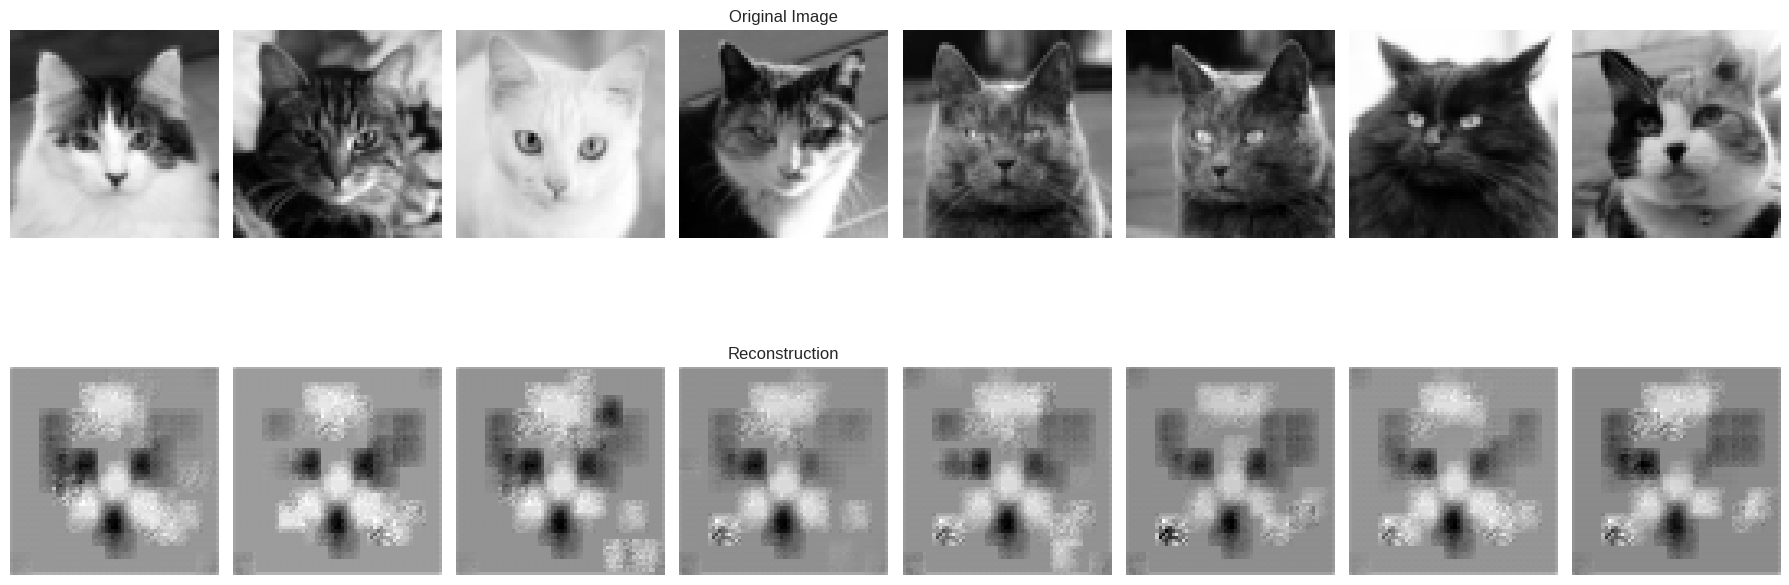

In [66]:
lambda_kld_values = [1e-4, 1e-3, 1e-2, 1e-1]
for kld_value in lambda_kld_values:
    LATENT_DIM = 10
    conv_vae = VAE.ConvVAE(latent_dim=LATENT_DIM).to(device)
    optimizer = torch.optim.Adam(conv_vae.parameters(), lr=3e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
    writer = helper.new_writer("models","ConvVAE+{kld_value}")
    train = Wrapper(model_name="ConvVAE+{kld_value}", model = conv_vae, device = device, criterion = helper.vae_loss_function,lambda_kld=kld_value, optimizer = optimizer,writer=writer,show_progress_bar= False,print_epoch_values=False)
    train.train(10,train_loader,test_loader)
    writer.close()
    print(f"kld_weight = {kld_value}")
    train.plot_loss_acc()
    helper.show_recons_test(test_loader,conv_vae,device)

For each value of  $\lambda_{kld}$, we trained the ConvVAE model on the same dataset under consistent conditions (e.g., number of epochs, optimizer, learning rate). The following observations highlight the influence of 
$\lambda_{kld}$ on reconstruction quality and latent space regularization, as well as the FID (Fréchet Inception Distance) scores which measures how similar the distributions of real images and generated images are in a high-level feature space:

### **Low $\lambda_{kld}$(e.g., $10^-{4}$):**

Reconstruction Quality: The model prioritizes accurate reconstruction of input images. With a low penalty on latent space regularization, more capacity is allocated to recreating inputs precisely.

Lower FID values were observed, indicating that the generated images closely match the distribution of real images. This reflects better quality and realism.

### **Moderate $\lambda_{kld}$(e.g., $10^{−3}$):**

Slight reduction in reconstruction quality compared to the lowest $\lambda_{kld}$ values. The model begins balancing reconstruction and latent space regularization.

The FID scores remain competitive but start to increase slightly, suggesting a small trade-off between reconstruction accuracy and latent space alignment.

### **High $\lambda_{kld}$(e.g., $10^{−2}$  and $10^{−1}$):**

Noticeable degradation in the quality of reconstructed images. With a higher focus on enforcing the latent space to match a standard normal distribution, the model sacrifices reconstruction fidelity.

The FID scores increase significantly, indicating a divergence from the distribution of real images. This reflects a decline in the realism and quality of generated images.

# ** Bonus (conditional ConvVAE)

Epoch 1 Iter 229: loss 0.03862.: 100%|██████████| 229/229 [00:06<00:00, 37.75it/s]


Train Loss 0.05239
Test Loss 0.03987
    Test recons_Loss 0.03434
    Test kld_Loss 5.5374


Epoch 2 Iter 229: loss 0.03517.: 100%|██████████| 229/229 [00:05<00:00, 38.23it/s]


Train Loss 0.03558
Test Loss 0.03303
    Test recons_Loss 0.02703
    Test kld_Loss 6.00713


Epoch 3 Iter 229: loss 0.03055.: 100%|██████████| 229/229 [00:06<00:00, 37.52it/s]


Train Loss 0.03327
Test Loss 0.03258
    Test recons_Loss 0.02531
    Test kld_Loss 7.27718


Epoch 4 Iter 229: loss 0.03281.: 100%|██████████| 229/229 [00:06<00:00, 35.93it/s]


Train Loss 0.03285
Test Loss 0.03261
    Test recons_Loss 0.02643
    Test kld_Loss 6.17887


Epoch 5 Iter 229: loss 0.03389.: 100%|██████████| 229/229 [00:07<00:00, 29.89it/s]


Train Loss 0.03273
Test Loss 0.03226
    Test recons_Loss 0.02512
    Test kld_Loss 7.13629


Epoch 6 Iter 229: loss 0.03110.: 100%|██████████| 229/229 [00:07<00:00, 30.05it/s]


Train Loss 0.03256
Test Loss 0.0322
    Test recons_Loss 0.02544
    Test kld_Loss 6.76024


Epoch 7 Iter 229: loss 0.03069.: 100%|██████████| 229/229 [00:07<00:00, 30.20it/s]


Train Loss 0.03249
Test Loss 0.03226
    Test recons_Loss 0.02555
    Test kld_Loss 6.71496


Epoch 8 Iter 229: loss 0.03340.: 100%|██████████| 229/229 [00:06<00:00, 33.73it/s]


Train Loss 0.03246
Test Loss 0.03208
    Test recons_Loss 0.02495
    Test kld_Loss 7.12579


Epoch 9 Iter 229: loss 0.03367.: 100%|██████████| 229/229 [00:08<00:00, 27.56it/s]


Train Loss 0.03247
Test Loss 0.0322
    Test recons_Loss 0.02519
    Test kld_Loss 7.00815


Epoch 10 Iter 229: loss 0.03003.: 100%|██████████| 229/229 [00:07<00:00, 28.64it/s]


Train Loss 0.03234
Test Loss 0.03212
    Test recons_Loss 0.02496
    Test kld_Loss 7.16039


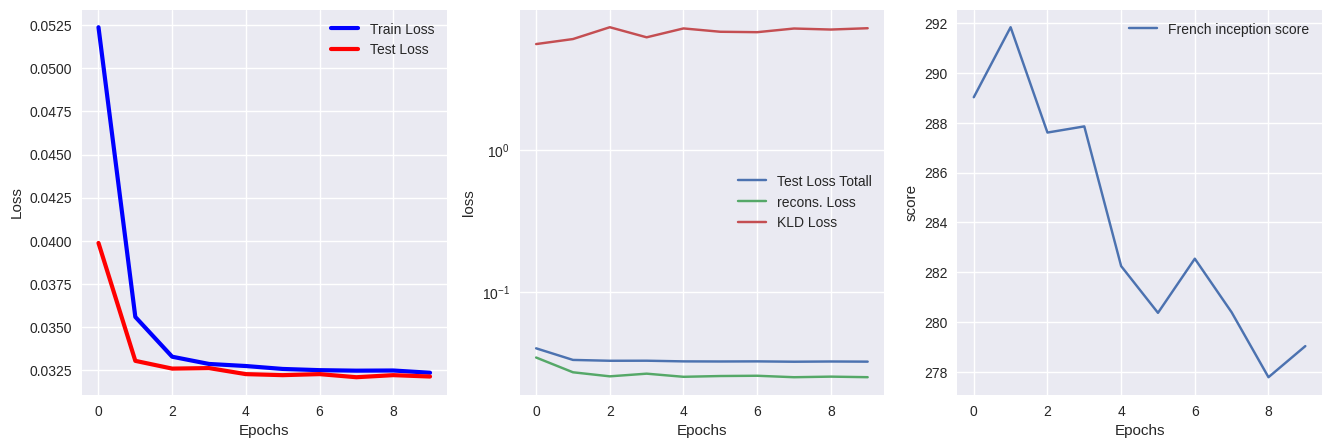

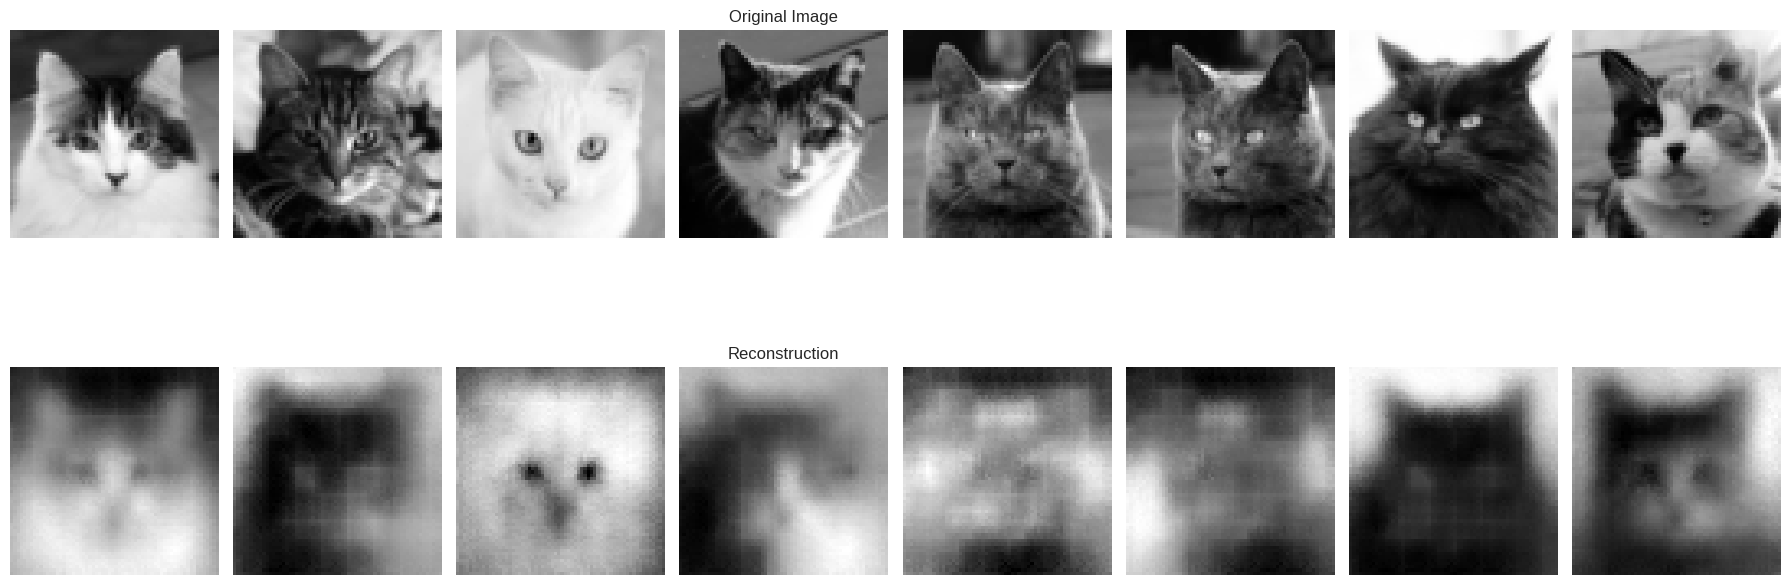

In [148]:
LATENT_DIM = 10
cond_conv_vae = VAE.ConditionalConvVAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(cond_conv_vae.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)
writer = helper.new_writer("models","cond_ConvVAE")
train = Wrapper(model_name="cond_ConvVAE", model = cond_conv_vae, device = device, criterion = helper.vae_loss_function, optimizer = optimizer,writer=writer,condition=True)
train.train(10,train_loader,test_loader)
writer.close()
train.plot_loss_acc()
helper.show_recons_test(test_loader,cond_conv_vae,device,condition=True)